In [2]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
  
# initialize parameters 
start_date = datetime(2014, 1, 1) 
end_date = datetime(2024, 1, 1)

In [4]:
# get the data for Merck
data = yf.download('MRK', start = start_date, 
                   end = end_date)

[*********************100%%**********************]  1 of 1 completed


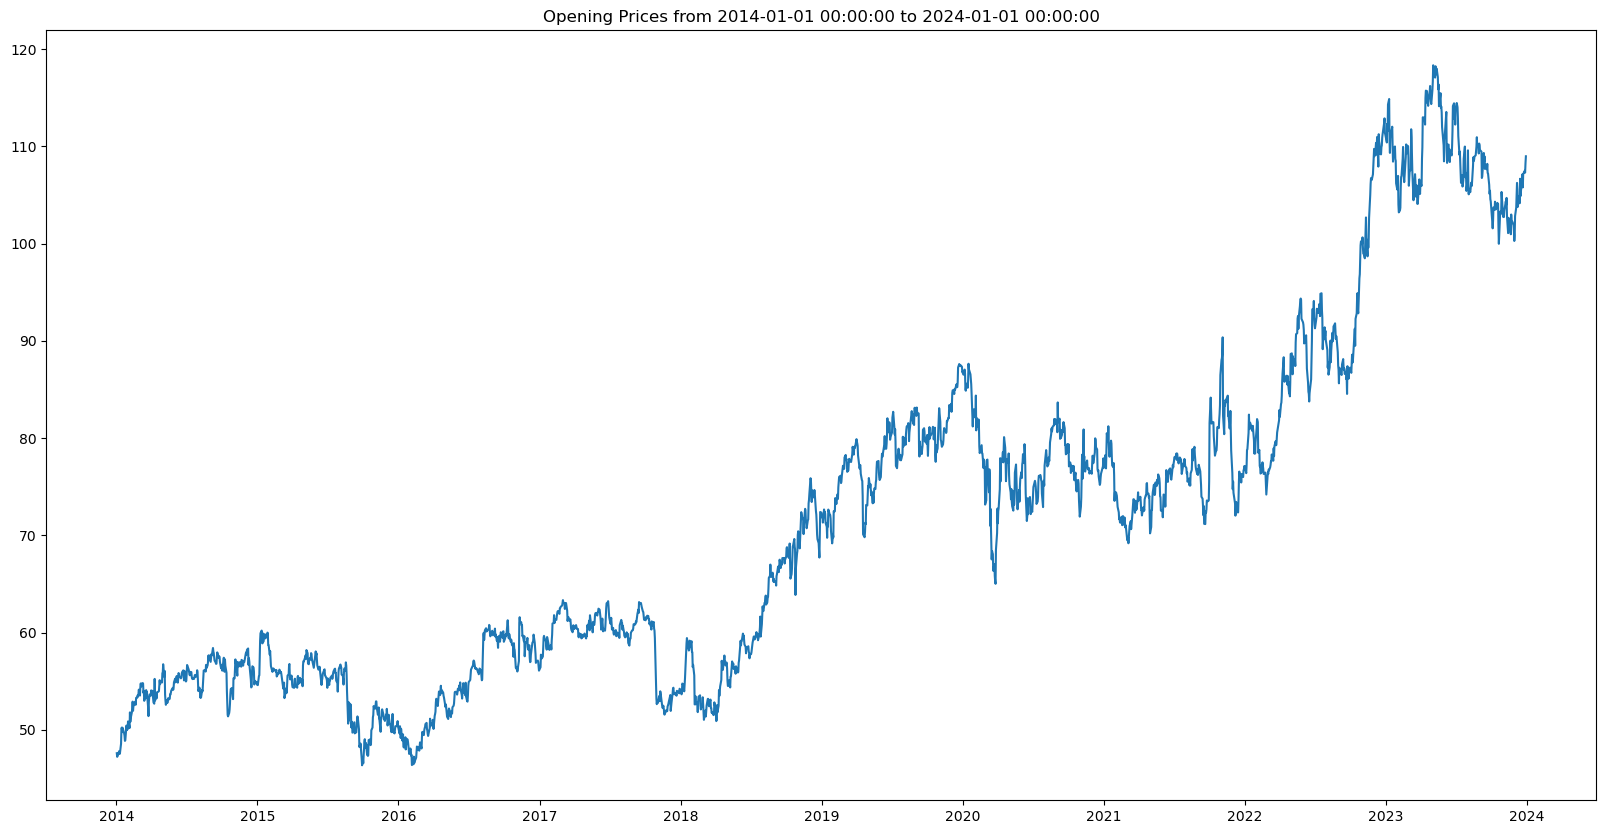

In [8]:
# display 
plt.figure(figsize = (20,10)) 
plt.title('Opening Prices from {} to {}'.format(start_date, 
                                                end_date)) 
plt.plot(data['Open']) 
plt.show()

In [9]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,47.595421,47.748093,47.041985,47.223282,34.701138,8265052
2014-01-03,47.223282,47.709923,47.194656,47.452290,34.869408,6743880
2014-01-06,47.528625,47.843510,47.242367,47.461830,34.876427,10408107
2014-01-07,47.671757,48.091602,47.652672,47.814884,35.135853,10475598
2014-01-08,47.805344,47.843510,47.328243,47.509541,34.911469,14353094
...,...,...,...,...,...,...
2023-12-22,107.150002,108.059998,106.839996,107.699997,107.699997,6028100
2023-12-26,107.500000,108.089996,107.220001,107.629997,107.629997,4727700
2023-12-27,107.309998,108.070000,107.010002,107.980003,107.980003,5387000


In [13]:
import os
import pandas as pd

# attempt to create a stock predictor from MRK Data

In [14]:
data_path = "mrk_data.json"
if os.path.exists(data_path):
    #read from the file if we've already downloaded the data
    with open(data_path) as f:
        mrk_hist = pd.read_json(data_path)
else:
    mrk_hist = yf.download('MRK', start = start_date, 
                   end = end_date)
    mrk_hist.to_json(data_path)

In [15]:
# open - the price the stock opened at
# high - the highest price during the day
# low - the lowest price during the day
# close - the closing price on the trading day
# volume - how many shares were tradd

mrk_hist.head(5)

,Open,High,Low,Close,Adj Close,Volume
2014-01-02,47.595421,47.748093,47.041985,47.223282,34.701138,8265052
2014-01-03,47.223282,47.709923,47.194656,47.452290,34.869408,6743880
2014-01-06,47.528625,47.843510,47.242367,47.461830,34.876427,10408107
2014-01-07,47.671757,48.091602,47.652672,47.814884,35.135853,10475598
2014-01-08,47.805344,47.843510,47.328243,47.509541,34.911469,14353094


<AxesSubplot:>

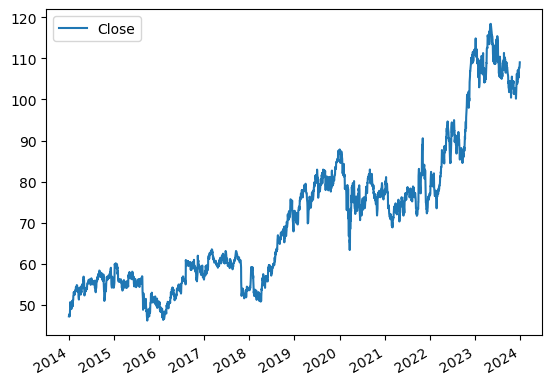

In [16]:
mrk_hist.plot.line(y="Close", use_index=True)

In [17]:
#ensure we know the actual closing price
data = mrk_hist[["Close"]]
data = data.rename(columns={'Close':'Actual_Close'})

#setup our target. This identifies if the price went up or down
data["Target"] = mrk_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [18]:
data.head()

,Actual_Close,Target
2014-01-02,47.223282,NaN
2014-01-03,47.452290,1.0
2014-01-06,47.461830,1.0
2014-01-07,47.814884,1.0
2014-01-08,47.509541,0.0


In [19]:
# shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
mrk_prev = mrk_hist.copy()

In [20]:
mrk_prev = mrk_prev.shift(1)

In [21]:
mrk_prev.head()

,Open,High,Low,Close,Adj Close,Volume
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,47.595421,47.748093,47.041985,47.223282,34.701138,8265052.0
2014-01-06,47.223282,47.709923,47.194656,47.452290,34.869408,6743880.0
2014-01-07,47.528625,47.843510,47.242367,47.461830,34.876427,10408107.0
2014-01-08,47.671757,48.091602,47.652672,47.814884,35.135853,10475598.0


In [22]:
# create training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(mrk_prev[predictors]).iloc[1:]

In [23]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
2014-01-03,47.452290,1.0,47.223282,8265052.0,47.595421,47.748093,47.041985
2014-01-06,47.461830,1.0,47.452290,6743880.0,47.223282,47.709923,47.194656
2014-01-07,47.814884,1.0,47.461830,10408107.0,47.528625,47.843510,47.242367
2014-01-08,47.509541,0.0,47.814884,10475598.0,47.671757,48.091602,47.652672
2014-01-09,47.251907,0.0,47.509541,14353094.0,47.805344,47.843510,47.328243


In [25]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model
# - meta estimator that fits a number of decision tree classifiers as subsamples of the dataset
# - uses averaging to improve the predictive accuracy and controls over-fitting
# - trees in the forest use the best split strategy. Equivalent to passing splitter="best" to the underlying DecisionTreeRegressor
# - sub-sample size is controlled with max_samples param if bootstrap=True
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


# Set min_samples_split high to ensure we don't overfit

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)



In [28]:
# create a train and test set

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=200, random_state=1)

In [29]:
# check how accurate the model is
from sklearn.metrics import precision_score

# evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
precision_score(test["Target"], preds)


0.52

<AxesSubplot:>

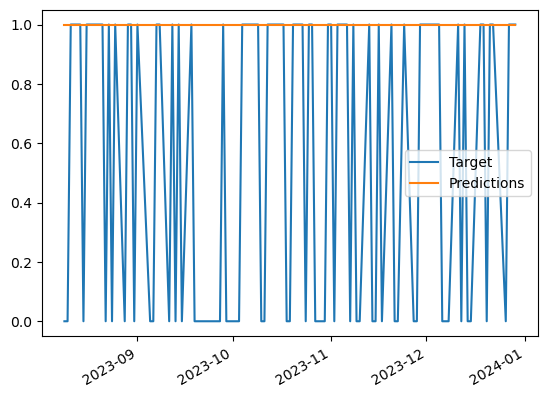

In [30]:
# Plot the prediction vs actual

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [32]:
# Backtesting
# We want to use more than 100 days worth of data
# To test on more days, we want to backtest to ensure that we only use data from before that we're predicting.
# If we use data from after the day we're predicting, the algorithm is unrealistic

# Our backtesting method will loop over the dataset and train a model every 750 rows
# Make it a function so we can avoid rewriting if we want to backtest again.
# IRL we'd train a model more often than every 750 rows, but for speed we'll set the number high

#Single Iteration
# - Take the first 1000 rows of data as training
# - Take the next 750 rows as testing
# - Fit our ML model to training
# - Make predictions on test


i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])


In [33]:
# Predicting Probabilities

# Using predict method doesn't optimize for precision, which we care about
# Instead use predict_proba to get raw probabilities, not just 0/1

preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds <= .6] = 0

In [34]:
preds.head()

2017-12-21    1.0
2017-12-22    0.0
2017-12-26    0.0
2017-12-27    0.0
2017-12-28    0.0
dtype: float64

In [35]:
# Pull these into a loop. Iterate across the entire dataset, generate predictions, and add into the predictions list.
# Generate predictions for all but the first 1000 rws, because there's no previous data we can use to predict those rows

# Loop:
# - Generate predictions on our train and test set
# - Combine those predictions with the actual target
# - Add all the predictions into one list

# Place the loop in a function
# - Take the data, the machene learning model and the predictors as inputs
# - Set a start and step as optional parameters
# - Split the training and the test data
# - Train a model
# - make the predictions using predict_proba
# - Combine predictions with the actual target to calculate error easily
# - Return all of the predictions



def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [36]:
predictions = backtest(data, model, predictors)


In [37]:
# use the value_counts method to determine how many times it ould go up versus down
# If we used a lower thresold from .6, we would increase recall but lower precision
# Since we want to minimize risk and maximize precision, it's ok to predict the price will go up on few days

predictions["Predictions"].value_counts()


0.0    1499
1.0      16
Name: Predictions, dtype: int64

In [38]:
predictions["Target"].value_counts()

1.0    783
0.0    732
Name: Target, dtype: int64

In [39]:
precision_score(predictions["Target"], predictions["Predictions"])

# Model isn't very accurate. To make the model more useful, we have to improve accuracy

0.625

In [40]:
# Adding some rolling means to evaluate the current price against recent prices

# calculate rolling averages on a weekly, quarterly, and annual basis

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [41]:
# Tell the algorithm how many days in the last week the price has gone up, using the .rolling() method
# Shift the data forward so we're not using the current day in the predictor

weekly_trend = data.shift(1).rolling(7).sum()["Target"]


weekly_trend

2014-01-03    NaN
2014-01-06    NaN
2014-01-07    NaN
2014-01-08    NaN
2014-01-09    NaN
             ... 
2023-12-22    4.0
2023-12-26    4.0
2023-12-27    4.0
2023-12-28    5.0
2023-12-29    5.0
Name: Target, Length: 2515, dtype: float64

In [42]:
# add ratos into predictor data frame
# first add the ratios  between weekly, quarterly, and annual means to the close
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [43]:
# add ratios between the different rolling means
# helps the algorithm understand what weekly trend is relative to the annual trend

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [44]:
# add weekly trend into the predictor dataframe

data["weekly_trend"] = weekly_trend


In [45]:
# add intraday open, low, and high ratios

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [46]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]


In [47]:
predictions = backtest(data.iloc[365:], model, full_predictors)


In [48]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5238095238095238